In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion() # 대화형 모드

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [15]:
data_dir = '/Users/jihopark/Data/hymenoptera_data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [56]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

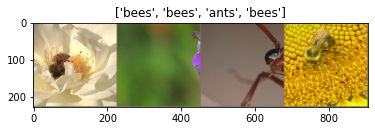

In [59]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [68]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best val Acc: {:.4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [63]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return 

In [64]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [33]:
model_df = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5132 Acc: 0.7705
val Loss: 0.3035 Acc: 0.8824

Epoch 1/24
----------
train Loss: 0.7380 Acc: 0.7254
val Loss: 0.3408 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.6716 Acc: 0.7582
val Loss: 0.5661 Acc: 0.8497

Epoch 3/24
----------
train Loss: 0.6692 Acc: 0.7869
val Loss: 0.2795 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.4732 Acc: 0.8074
val Loss: 0.3450 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.5159 Acc: 0.8074
val Loss: 0.2629 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.5512 Acc: 0.7787
val Loss: 0.3593 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.3737 Acc: 0.8279
val Loss: 0.2943 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3514 Acc: 0.8156
val Loss: 0.3076 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.3088 Acc: 0.8525
val Loss: 0.2911 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.2956 Acc: 0.8811
val Loss: 0.2876 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.3498 Acc: 0.8320
val Loss: 0.2854 Acc: 0.9085

Ep

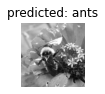

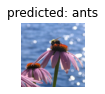

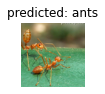

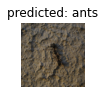

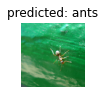

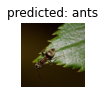

In [65]:
visualize_model(model_ft)

### 고정된 특징 추출기로써 CNN 활용

In [69]:
model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [70]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6040 Acc: 0.6557
val Loss: 0.2062 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.3909 Acc: 0.8279
val Loss: 0.4113 Acc: 0.8366

Epoch 2/24
----------
train Loss: 0.6658 Acc: 0.7418
val Loss: 0.1619 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.5452 Acc: 0.7664
val Loss: 0.2135 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.4696 Acc: 0.8074
val Loss: 0.4502 Acc: 0.8301

Epoch 5/24
----------
train Loss: 0.4978 Acc: 0.7992
val Loss: 0.6382 Acc: 0.8170

Epoch 6/24
----------
train Loss: 0.4118 Acc: 0.8238
val Loss: 0.3777 Acc: 0.8824

Epoch 7/24
----------
train Loss: 0.3671 Acc: 0.8402
val Loss: 0.1986 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3906 Acc: 0.8197
val Loss: 0.2366 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.2872 Acc: 0.8607
val Loss: 0.1974 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3298 Acc: 0.8852
val Loss: 0.2170 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3214 Acc: 0.8689
val Loss: 0.2065 Acc: 0.9412

Ep

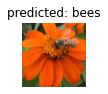

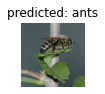

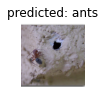

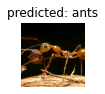

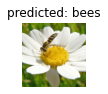

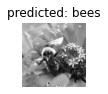

In [72]:
visualize_model(model_conv)

plt.ioff()
plt.show()